<a href="https://colab.research.google.com/github/abidur0177/Convolutional_Neural_Network/blob/main/Cat_Dog_Classification_With_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# In this project I have defined a convolutional neural network to distinguish between cat and dog images. This is a binary classification task in nature and the dataset is much larger than the horse_or_human classification. To avoid the overfitting problem, I will use data augmentation as well as transfer learning using InceptionV3 architecture. For the transfer learning, only the convolution layers will be in use and I will build the rest feed forward architecture by myself.

### Import the libaries

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

### Download the pre_trained model weights.

In [5]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2024-05-04 22:19:32--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.107.207, 173.194.202.207, 173.194.203.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.107.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  51.3MB/s    in 1.6s    

2024-05-04 22:19:33 (51.3 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [11]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers

# Assign the weight file to a variable
local_weights = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Initialize the pre_trained model while dropping the top layer (Feed forward architecture)
pre_trained_model = InceptionV3(input_shape=(150,150,3),
                                include_top=False,
                                weights=None)

# Set the model weights
pre_trained_model.load_weights(local_weights)

# Freeze the weights of the model
for layer in pre_trained_model.layers:
  layer.trainable = False

In [12]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d_282 (Conv2D)         (None, 74, 74, 32)           864       ['input_4[0][0]']             
                                                                                                  
 batch_normalization_282 (B  (None, 74, 74, 32)           96        ['conv2d_282[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_282 (Activation  (None, 74, 74, 32)           0         ['batch_normalizati

In [15]:
# Set the 'mixed7' layer as the last layer of the convolution network architecture
last_layer = pre_trained_model.get_layer('mixed7')
print(f'Last layer output shape: {last_layer.output_shape}')
last_output = last_layer.output
last_output

Last layer output shape: (None, 7, 7, 768)


<KerasTensor: shape=(None, 7, 7, 768) dtype=float32 (created by layer 'mixed7')>

### Create my own neural network and append it with the pre_trained model

In [18]:
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop

# Define the flatten layer
x = layers.Flatten()(last_output)
# Define the dense layer
x = layers.Dense(1024, activation=tf.nn.relu)(x)
# Define a dropout rate of 20%
x = layers.Dropout(0.2)(x)
# Final output layer
x = layers.Dense(1, activation=tf.nn.sigmoid)(x)

# Append the model with the pre_trained model
model = Model(pre_trained_model.input, x)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d_282 (Conv2D)         (None, 74, 74, 32)           864       ['input_4[0][0]']             
                                                                                                  
 batch_normalization_282 (B  (None, 74, 74, 32)           96        ['conv2d_282[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_282 (Activation  (None, 74, 74, 32)           0         ['batch_normalization_282[

In [20]:
model.compile(optimizer=RMSprop(learning_rate=0.001),
              loss=keras.losses.BinaryCrossentropy(),
              metrics = keras.metrics.Accuracy())

### Prepare the dataset

In [21]:
# Download the dataset
!wget https://storage.googleapis.com/tensorflow-1-public/course2/cats_and_dogs_filtered.zip

--2024-05-04 22:38:55--  https://storage.googleapis.com/tensorflow-1-public/course2/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.107.207, 173.194.202.207, 173.194.203.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.107.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M  74.8MB/s    in 0.9s    

2024-05-04 22:38:56 (74.8 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [23]:
import os
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Extract the archive
zip_ref = zipfile.ZipFile("./cats_and_dogs_filtered.zip", 'r')
zip_ref.extractall("tmp/")
zip_ref.close()

# Define our example directories and files
base_dir = 'tmp/cats_and_dogs_filtered'

train_dir = os.path.join( base_dir, 'train')
validation_dir = os.path.join( base_dir, 'validation')

# Directory with training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# The validation data is not augmented
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary',
                                                    target_size = (150, 150))

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary',
                                                          target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### Train the model

In [25]:
# Train the model. only for two epoch due to runtime
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 2,
            validation_steps = 50,
            verbose = 2)

Epoch 1/2
100/100 - 184s - loss: 0.3745 - accuracy: 0.0435 - val_loss: 0.0918 - val_accuracy: 0.0500 - 184s/epoch - 2s/step
Epoch 2/2
100/100 - 172s - loss: 0.2344 - accuracy: 0.0580 - val_loss: 0.2247 - val_accuracy: 0.1200 - 172s/epoch - 2s/step


### Evaluate the result

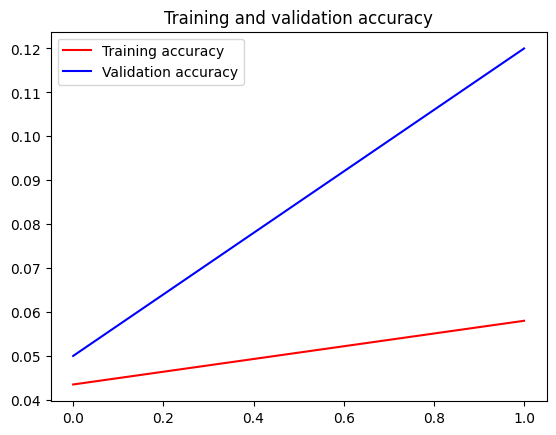

<Figure size 640x480 with 0 Axes>

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()